# The HFM library - A fast marching solver with adaptive stencils

## Part : Non holonomic metrics and curvature penalization
## Chapter : Customized curvature penalization

This notebook presents a re-implementation of the Reeds-Shepp sub-Riemannian model, using a three dimensional Riemannian metric of strong anisotropy on a domain with suitable periodic boundary conditions.

Two customizations are then discussed, in connection with an image processing application, tubular structure segmentation. 
* *curvature prescription*, instead of curvature penalization
* *deviation from horizontality*, a data-driven modification of the original sub-Riemannian model

We then show how a similar effect can be achieved with other non-holonomic models implemented in the HFM library, which implement different and often stronger forms of curvature penalization. Namely the Reeds-Sheep *forward* model (without reverse gear), the Euler elastica model (squared penalization of curvature), and the Dubins model (uniform bound on curvature).

**Reader notice**. A general knowledge of the Reeds-Shepp sub-Riemannian model is required in the first part of this notebook.

**Acknowledgement**. This notebook is part of a work in progress in collaboration with [Remco Duits](https://www.win.tue.nl/~rduits/), [Erik Bekkers](https://erikbekkers.bitbucket.io), [Laurent Cohen](https://www.ceremade.dauphine.fr/~cohen/), and [Da Chen](https://www.researchgate.net/profile/Da_Chen9). 

**References**. The experiments presented in this notebook are inspired by the following publications.

Duits, R., Meesters, S. P., Mirebeau, J.-M., & Portegies, J. M. (2018). Optimal paths for variants of the 2D and 3D Reeds-Shepp car with applications in image analysis. Journal of Mathematical Imaging and Vision, 1–33. http://doi.org/ https://doi.org/10.1007/s10851-018-0795-z

Chen, D., Mirebeau, J.-M., & Cohen, L. D. (2015). Global Minimum for Curvature Penalized Minimal Path Method. In M. W. J. Xianghua Xie & G. K. L. Tam (Eds.), (pp. 86.1–86.12). Presented at the Proceedings of the British Machine Vision Conference (BMVC), BMVA Press. http://doi.org/10.5244/C.29.86

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Re-creating the Reeds-Shepp model.](#1.-Re-creating-the-Reeds-Shepp-model.)
  * [2. A synthetic tubular segmentation problem](#2.-A-synthetic-tubular-segmentation-problem)
  * [3. Tubular structure extraction - cost based methods](#3.-Tubular-structure-extraction---cost-based-methods)
    * [3.1 Isotropic metric](#3.1-Isotropic-metric)
    * [3.2 Reeds-Shepp metric](#3.2-Reeds-Shepp-metric)
    * [3.3 Possible issues](#3.3-Possible-issues)
  * [4. Data-driven customization of the Reeds-Shepp model](#4.-Data-driven-customization-of-the-Reeds-Shepp-model)
    * [4.1 Deviation from horizontality](#4.1-Deviation-from-horizontality)
    * [4.2 Prescribing curvature](#4.2-Prescribing-curvature)
    * [4.3 Combining deviation from horizontality and curvature prescription](#4.3-Combining-deviation-from-horizontality-and-curvature-prescription)
  * [5. Other curvature penalization models](#5.-Other-curvature-penalization-models)
    * [5.1 The extended Reeds-Shepp model](#5.1-The-extended-Reeds-Shepp-model)
    * [5.2 Other models](#5.2-Other-models)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
#Colab : !pip install agd

In [2]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('DeviationHorizontality','FMM'))

In [3]:
from agd import Eikonal
from agd.Metrics import Riemann # Riemannian metric
from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd.Plotting import savefig, SetTitle3D; #savefig.dirName = 'Figures/DeviationHorizontality/'

from agd.LinearParallel import outer_self as Outer # outer product v v^T of a vector with itself
norm = ad.Optimization.norm

In [4]:
import numpy as np; xp=np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Plots 3D paths

useMayavi = False
if useMayavi:
    from mayavi import mlab # Plots implicit surfaces

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,Riemann,ad,lp
    [Eikonal,Riemann,ad,lp] = rreload([Eikonal,Riemann,ad,lp],rootdir='..')

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver. (Comment it for the CPU eikonal solver.)

In [6]:
#Colab : xp,plt,Eikonal = map(ad.cupy_friendly,(xp,plt,Eikonal))

## 1. Re-creating the Reeds-Shepp model. 

The Reeds-Shepp model is presumably the most well known instance a *sub-Riemannian* model. This is empirically described as a Riemannian model whose metric tensors have infinite eigenvalues. Our implementation is based on relaxation of the sub-Riemannian constraint, replacing these infinite eigenvalues with a suitably large value denoted $\varepsilon^{-2}$.

The Reeds-Shepp model is posed on the three dimensional domain $R^2 \times S^1$, whose third dimension is periodic.
The relaxed metric, at position $(x,\theta)$ and evaluated on tangent vector $(\dot x, \dot \theta)$, reads
$$
    F_{(x,\theta)}(\dot x, \dot \theta) = <\dot x,n(\theta)>^2 
    {+} \varepsilon^{-2} <\dot x,n(\theta)^\perp>^2 
    {+} \xi^2 |\dot \theta|^2,
$$
where $n(\theta) := (\cos \theta, \sin \theta)$.
The parameter $\xi>0$, homogeneous to a length, balances the amount of curvature penalization, and should be regarded as a typical radius of curvature. 

The Reeds-Shepp model corresponds to the cost of motion of a wheelchair-like vehicle. The coordinates $(x,\theta)\in R^2 \times S^1$ reflect the current state of the vehicle, comprised of a position $x$ and an orientation $\theta$.
The three terms appearing in this metric dictate respectively 
* The cost of forward motion, in the direction $n(\theta)$.
* An extremely large price for lateral motion, in the direction $n(\theta)^\perp$. Such motions are forbidden for the vehicles considered, and their cost tends to $\infty$ as $\epsilon \to 0$.
* The cost of angular motion.

**Anticipation** The first step of this notebook is to reproduce the original Reeds-Shepp model. Let us nevertheless anticipate on the data-driven, application dependent, customizations that we will develop.
* *State dependent cost*. Multiplying the whole metric by a data-driven cost function $c(x,\theta)^2$, smaller in regions where motion should be favored.
* *Deviation from horizontality*. Replacing $n(\theta)$ with a data driven direction $n(x,\theta)$, corresponding to a locally preferred direction of motion.
* *Prescribed curvature*. Subtracting $\kappa <n(\theta),\dot x>$, where $\kappa$ is a reference curvature, to the angular motion speed $\dot \theta$. The same effect can be achieved in other ways as well.

In [7]:
eps = 0.1 # Small parameter, for penalizing the sub-Riemannian constraint.
xi = 0.5 # Typical radius of curvature.

We use the domain $[-1,1] \times [-0.4,0.4] \times [-\pi,\pi]$, with periodic boundary conditions on the last coordinate.

In [8]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann3_Periodic', # The third dimension is periodic (and only this one), in this model.
    'seed':[0.,0.,0.],
    'arrayOrdering':'RowMajor',
    'tips':[[x,y,t] for x in Eikonal.CenteredLinspace(-1,1,2) 
            for y in Eikonal.CenteredLinspace(-0.5,0.5,2)
           for t in [np.pi/3,2*np.pi/3]],
})
hfmIn.SetRect(sides=[[-1,1],[-0.4,0.4],[-np.pi,np.pi]],dims=[101,40,101])
X,Y,Theta = hfmIn.Grid()
zero = np.zeros_like(X)

In [9]:
if hfmIn.mode=='gpu': hfmIn.update({'model':'Riemann3','periodic':(False,False,True)})

On implémente ici l'approximation Riemannienne de la métrique du modèle de Reeds-Shepp, qui prend la forme matricielle
$$
    M(x,\theta) = 
    \begin{pmatrix}
    n(\theta) n(\theta)^T + \epsilon^{-2} n(\theta)^\perp (n(\theta)^\perp)^T & \\
    & \xi^2
    \end{pmatrix}.
$$




*Question 1*
===
Implémenter cette métrique, en utilisant la classe `agd.Metrics.Riemann`, qui prend en entrée un tableau de taille 
$(d,d,n_1,\cdots,n_d)$ décrivant les matrices SDP constituant la métrique.


In [10]:
c=np.cos(Theta); s = np.sin(Theta); z = np.zeros_like(Theta); u=np.ones_like(Theta);
μ=eps**-2

# n(θ)=(c,s)
# n(θ)^\perp = (-s,c)

ReedsSheppMetric = Riemann([
    [c**2 +μ*s**2, c*s - μ*c*s,z],
    [c*s-μ*c*s,    s**2+μ*c**2,z],
    [z,               z, xi**2*u]
])


In [11]:
hfmIn['metric'] = ReedsSheppMetric

In [12]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.10961 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


The planar projections of the Reeds-Shepp minimal geodesics feature *cusps*, which are characteristic feature of sub-Riemannian models.

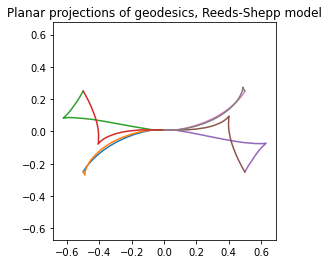

In [13]:
fig = plt.figure(figsize=[4,4]); plt.title('Planar projections of geodesics, Reeds-Shepp model'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 

Note that the genuine three dimensional geodesics in $R^2 \times S^1$ are smooth.

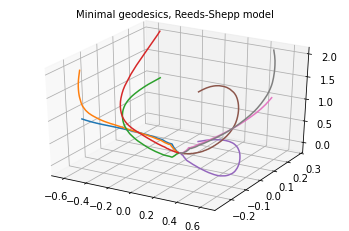

In [24]:
fig = plt.figure(); ax = fig.gca(projection='3d'); SetTitle3D(ax,"Minimal geodesics, Reeds-Shepp model")
for geo in hfmOut['geodesics']: plt.plot(*geo)

## 2. A synthetic tubular segmentation problem

We construct a synthetic tubular segmentation problem, designed to illustrate minimal path based tubular extraction methods. The test case is chosen so as to induce the following difficulties:
* *Shortcuts* due to multiple crossings.
* *Strong curvature*, in some regions.

The image segmentation methods considered feature a preliminary filtering phase in which a number of features of the objects of interest are extracted. In particular it is typical to process, with more or less accuracy, the following quantities:
* A vesselness score, which is high on the tubular structure, and low elsewhere. 
* Some approximation of the tubular structure orientation.
* Some (weak) approximation of the tubular structure curvature.

In this synthetic test case, we do not attempt to implement the varied and complex image processing techniques involved to extract the above quantities, but directly construct them from the data.

In [14]:
def γ(t, height=0.3): return ad.array([np.sin(t), height*np.cos(3*t)])

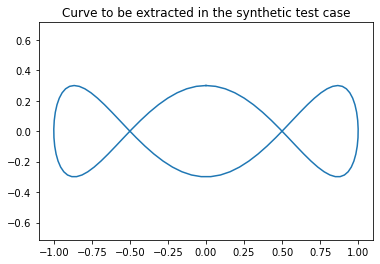

In [15]:
T = np.linspace(0,2*np.pi,100)
plt.title("Curve to be extracted in the synthetic test case"); plt.axis('equal')
plt.plot(*γ(T));

We rely on automatic differentiation to compute the tangent and curvature of $\gamma$.

In [23]:
def tangent(γ,t):
    """Returns the normalized tangent to a curve gamma"""
    t_ad = ad.Dense.identity(constant=t, shape_free=tuple())
    γ_p = γ(t_ad).gradient(0) # gamma'
    return γ_p / norm(γ_p,axis=0) 

def curvature(γ,t):
    """Returns the curvature of a planar curve gamma"""
    t_ad = ad.Dense2.identity(constant=t, shape_free=tuple())
    γ_ad = γ(t_ad)
    γ_p  = γ_ad.gradient(0)
    γ_pp = γ_ad.hessian(0,0)
    return lp.det([γ_p,γ_pp]) / norm(γ_p,axis=0)**3

def lift(γ,t):
    """Orientation in [0,2*pi] of the tangent vector."""
    t_ad = ad.Dense.identity(constant=t, shape_free=tuple())
    γ_ad = γ(t_ad)
    γ_p = γ_ad.gradient(0) # gamma'
    return ad.array([*γ_ad.value, np.arctan2(γ_p[1],γ_p[0])])

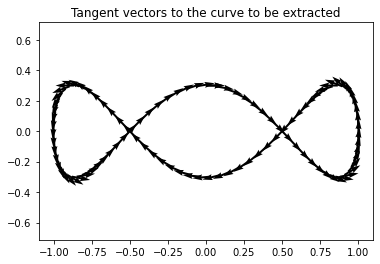

In [24]:
plt.title("Tangent vectors to the curve to be extracted"""); plt.axis('equal')
plt.quiver(*γ(T),*tangent(γ,T)); 

In [25]:
#plt.title("Radius of curvature of γ"""); plt.axis('equal')
#plt.quiver(*γ(T),*(lp.perp(tangent(γ,T))/curvature(γ,T))); 

We use a fast marching method to compute the distance to the curve $\gamma$, which will be used to emulate a vesselness score. We also extend the tangent vector and curvature defined on $\gamma$ to the whole domain, based on the nearest value.

A small cost is used for the vertical coordinate, to account for the fact that a tubular structure direction is more difficult to extract than its position. 

In [26]:
IsotropicMetric = Riemann([
    [1.,0.,0.],
    [0.,1.,0.],
    [0.,0.,0.1**2] 
])

In [27]:
hfmIn.update({
    'metric' :IsotropicMetric,
    'seeds' : lift(γ,T).T,
    'seedValueVariation' : [*tangent(γ,T),curvature(γ,T)],
    'exportValues' : 1,
})
#hfmIn.pop('tips',None);

In [28]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.656698 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [29]:
values = hfmOut['values']
γ_dist     = values.value
γ_tgt_ext  = values.gradient([0,1])
γ_curv_ext = values.gradient(2)

In [30]:
if useMayavi:
    mlab.contour3d(γ_dist, contours=[0.1])
    mlab.show() # Displays in an external window.

This is what the previous command should display.
![Solution level set](https://rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks_FMM/images/A9_CurveNeighborhood.png)

We have extended the tangents to the curve $\gamma(t)$ to a three dimensional vector field $v(x,\theta)$ defined in the domain $[-1,1] \times [-0.4,0.4] \times [-\pi,\pi]$. Note that the curve $\gamma$ has self intersections, hence the vector field *does* depend on the angular coordinate. At a self intersection point of $\gamma$, where several tangents exist, the vector extension $v(x,\theta)$ selects the one closest to $\theta$.

We illustrate these properties with some slices of the extension $V$, here denoted `γ_tgt_ext`. Note that in applications, which do not involve synthetic as here, the identification of the orientation of structures and its extension requires other methods. See the discussion in the [notebook on tubular structure segmentation](Tubular.ipynb).

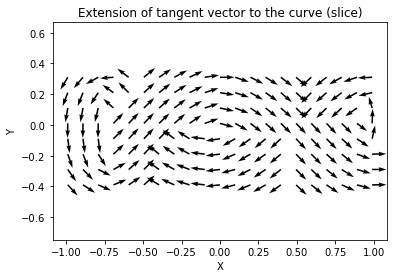

In [31]:
plt.title("Extension of tangent vector to the curve (slice)")
plt.xlabel('X'); plt.ylabel('Y'); plt.axis('equal')
plt.quiver(X[::5,::5,0],Y[::5,::5,0],*γ_tgt_ext[:,::5,::5,30]);

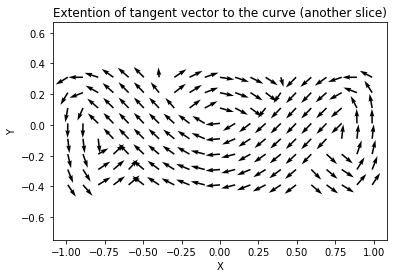

In [32]:
plt.title("Extention of tangent vector to the curve (another slice)")
plt.xlabel('X'); plt.ylabel('Y'); plt.axis('equal')
plt.quiver(X[::5,::5,0],Y[::5,::5,0],*γ_tgt_ext[:,::5,::5,0]);

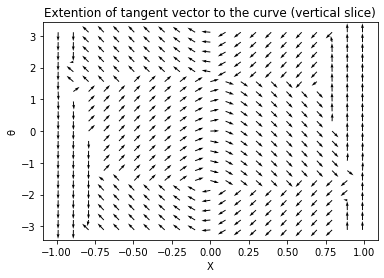

In [33]:
plt.title("Extention of tangent vector to the curve (vertical slice)")
plt.xlabel('X'); plt.ylabel('θ');
plt.quiver(X[::5,20,::5],Theta[::5,20,::5],*γ_tgt_ext[:,::5,20,::5]);

In [34]:
X.shape

(101, 40, 101)

In [35]:
for key in ['metric','seedValueVariation','exportValues']: hfmIn.pop(key,None)

## 3. Tubular structure extraction - cost based methods

In order to extract a tubular structure of interest, one first produces a cost function that is decreasing w.r.t. the vesselness score. Here it is based on simulated data. The construction of a vesselness score and of the related cost functions is discussed in the [notebook on tubular structure segmentation](Tubular.ipynb).





*Question 2*
===
Implémenter une fonction synthétique qui favorise les chemins proches de la courbe $\gamma$, avec l'expression
$$
    c(x) = (\alpha + \exp(-d(x, \gamma)^2/\sigma^2))^{-1}.
$$
Noter que l'inverse de $c(x)$ s'interprète comme une vitesse de propagation. On choisira $\alpha = 0.3$, $\sigma=0.2$.


In [36]:
γ_dist.shape

(101, 40, 101)

In [42]:
α=0.3; σ=0.2;
γ_cost = (α+np.exp(-γ_dist**2/σ**2) )**-1

Then one can multiply a given base metric by the cost function, and extract the shortest path between two given points of the domain.

### 3.1 Isotropic metric

We apply the previous strategy with an isotropic metric.

In [47]:
IsotropicMetric.m

array([[1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.01]])

In [48]:
IsotropicMetric_Cost =  IsotropicMetric.with_cost(γ_cost) 

In [49]:
hfmIn.update({
    'metric': IsotropicMetric_Cost,
     # Seed and tip are on the lifted curve, with correct tangent orientation
    'seed':  lift(γ,-1),
    'tip':   lift(γ, 1), 
})

In [50]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.433259 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


 The tubular structure extraction fails, due to the *shortcuts problem*: since curvature is not penalized, the extracted path may jump from one branch of the tubular structure to another.

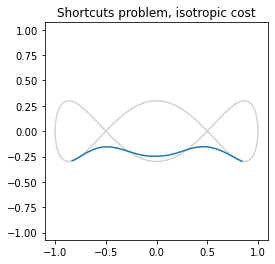

In [51]:
fig = plt.figure(figsize=[4,4]); plt.title('Shortcuts problem, isotropic cost'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);

### 3.2 Reeds-Shepp metric

Using a scaled Reeds-Shepp metric, we may both favor curves close to the tubular structure, and penalize curvature hence also shortcuts.

In [52]:
ReedsSheppMetric_Cost = ReedsSheppMetric.with_cost(γ_cost)

In [53]:
hfmIn['metric'] = ReedsSheppMetric_Cost

In [54]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.866333 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


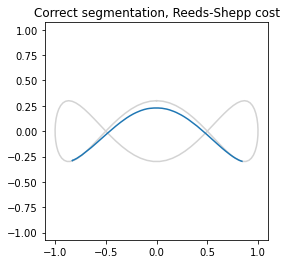

In [55]:
fig = plt.figure(figsize=[4,4]); plt.title('Correct segmentation, Reeds-Shepp cost'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);

### 3.3 Possible issues

The curvature penalization introduced with the Reeds-Shepp model may however create new difficulties, for at least two causes:
* *Sensitivity to the endpoints orientation*. If the angular coordinate of the seed or the tip is not correctly estimated, then the accuracy of the tubular structure extraction is degraded.
* *Difficulty to extract strongly curved portions*. Because of the curvature penalization, some parts of the tubular structure are hard to extract.

In [56]:
# Illustrating the problem with incorrect orientation at the seed and tip
hfmIn.update({
    'seed':(*γ(-1),-0.5),
    'tip': (*γ( 1),-1),  
})

In [57]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.754895 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


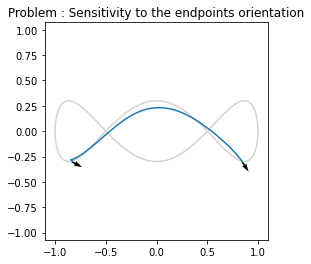

In [58]:
fig = plt.figure(figsize=[4,4]); plt.title('Problem : Sensitivity to the endpoints orientation'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);
for x,y,theta in (hfmIn['seed'],hfmIn['tip']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

In [59]:
# Illustrating the problem with far away seed an tip, and the presence of a strongly curved interval
hfmIn.update({
    'seed':lift(γ,-1),
    'tip': lift(γ,1.9),  
})

In [60]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.783793 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


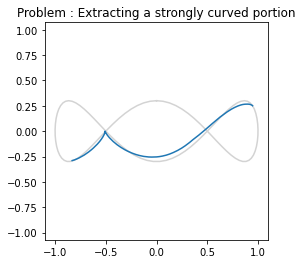

In [61]:
fig = plt.figure(figsize=[4,4]); plt.title('Problem : Extracting a strongly curved portion'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);

## 4. Data-driven customization of the Reeds-Shepp model

We present two modifications of the Reeds-Shepp model, designed to address the issues presented in 3.3.

### 4.1 Deviation from horizontality

The sub-Riemannian model is modified by forward motion direction $n(\theta) := (\cos \theta, \sin \theta)$ with an estimate of the tubular structure tangent direction, here produced synthetically. This compensates for a possible bad estimation of the tubular structure endpoints position or orientation.

The wording **Deviation from horizontality** is due to Remco Duits and refers to the sub-Riemannian terminology, in which the allowed directions of motion are referred to as the *horizontal* plane.

The (Riemannian relaxation of the sub-Riemannian) metric takes the form
$$
    F_{x,\theta}(\dot x,\dot \theta)^2 := c(x,\theta)^2 (<\dot x, v(x,\theta)>^2 + \epsilon^{-2} <\dot x, v(x,\theta)^\perp> + \xi^{-2} \dot \theta^2).
$$
Note that $v(x,\theta)\in S^1$ replaces $n(\theta) = (\cos \theta,\sin \theta)$ in the original Reeds-Shepp model.
The vector $v(x,\theta)$ is meant to approximate the curve tangent direction, when it the lifted curve is close to the position $(x,\theta)$. 




*Question 3*
===
Implémenter la métrique ci-dessus.


In [67]:
c,s = γ_tgt_ext
ReedsSheppMetric_CostDeviation = Riemann([
    [c**2 +μ*s**2, c*s - μ*c*s,z],
    [c*s-μ*c*s,    s**2+μ*c**2,z],
    [z,               z, xi**2*u]
])



In [64]:
hfmIn.update({
    'metric':ReedsSheppMetric_CostDeviation,
    'seed':[*γ(-1.),-0.5],
    'tip': [*γ(1.), -1],  
})

In [65]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.813655 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


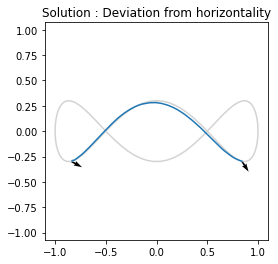

In [66]:
fig = plt.figure(figsize=[4,4]); plt.title('Solution : Deviation from horizontality'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);
for x,y,theta in (hfmIn['seed'],hfmIn['tip']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

Note the resilience to the bad guess (user provided) of the endpoints orientation.

### 4.2 Prescribing curvature

In this section, we describe a model where the extracted path curvature is not penalized absolutely, but with respect to some reference value, estimated from the tubular structure to be extracted. (Here produced synthetically.)

This avoids strongly penalizing path segments which are overlaid on strongly curved portions of the tubular structure. 

This effect can be achieved in two ways:
* Adequate modification of the Reeds-Shepp model.
* Construction of a cigar-shaped Riemannian metric in $R^2 \times S^1$, meaning that at each point the symmetric tensor has two large eigenvalues, while one is small. <!---(Note : strictly speaking, this is not a sub-Riemannian model.)-->

In the first case, the (Riemannian relaxation of sub-Riemannian) metric reads
$$
    F_{x,\theta}(\dot x,\dot \theta)^2 = c(x,\theta)^2 
    \Big(<\dot x,n(\theta)>^2 + \epsilon^{-2} <\dot x,n(\theta)^\perp>^2 + 
    \xi^2 (\dot \theta - \mu(x,\theta) <\dot x,n(\theta)>)^2 \Big),
$$
where $\mu(x,\theta)$ is an estimate of the desired path curvature at $(x,\theta)$, inferred from the data to be processed. Note that for a path parametrized at unit Euclidean speed in the physical domain, one has $<\dot x,n(\theta)> \approx 1$, and $\dot \theta$ is indeed the path curvature.




*Question 4*
===
Implémenter la métrique ci-dessus, avec $\mu(x,\theta)=$`γ_curv_ext`.


$$
    \int_0^L c(x(t),x'(t))\sqrt{1+ (\kappa(t)-\mu)^2) dt
$$

In [80]:
c = np.cos(Theta); s=np.sin(Theta)
ReedsSheppMetric_CostCurv = Riemann([
    [c**2 +μ*s**2, c*s - μ*c*s,z],
    [c*s-μ*c*s,    s**2+μ*c**2,z],
    [z,               z,       z]
])

ν=γ_curv_ext
w = np.array([ν*c,ν*s,-u]) # Rajouter ξ^2 w w^T à la métrique

for i in range(3):
    for j in range(3):
        ReedsSheppMetric_CostCurv.m[i,j] += xi**2 *w[i]*w[j]

ReedsSheppMetric_CostCurv.m *= γ_cost**2

In [81]:
hfmIn.update({    
    'metric':ReedsSheppMetric_CostCurv,
    'seed':lift(γ,-1.),
    'tip': lift(γ,1.9),  
})

In [82]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.34869 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


The strongly curved bottom-right portion of the curve is now correctly extracted.

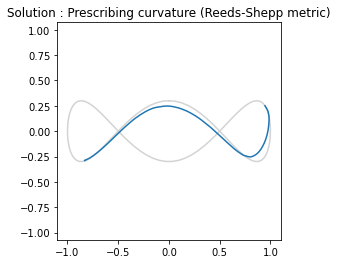

In [83]:
fig = plt.figure(figsize=[4,4]); plt.title('Solution : Prescribing curvature (Reeds-Shepp metric)'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);

In [49]:
# Second approach : cigar-shaped metric
v_Curv = ad.array([np.cos(Theta), np.sin(Theta), γ_curv_ext])
v_Curv /= np.sqrt(v_Curv[0]**2+v_Curv[1]**2+v_Curv[2]**2)

Identity = fd.as_field(xp.eye(3),γ_cost.shape)
CigarMetric_CostCurv = Riemann(
    Outer(v_Curv)
    + eps**(-2)*(Identity-Outer(v_Curv))
).with_cost(γ_cost)

In [50]:
hfmIn['metric']=CigarMetric_CostCurv

In [51]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.10384607315063477 seconds, and 131 iterations.
Post-Processing


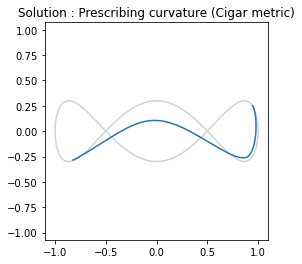

In [52]:
fig = plt.figure(figsize=[4,4]); plt.title('Solution : Prescribing curvature (Cigar metric)'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);

### 4.3 Combining deviation from horizontality and curvature prescription

The two previously methods can be combined, so as to extract highly curved tubular structures with inaccurate endpoints orientation. Again, one can either modify the Reeds-Shepp model, or produce a cigar-shaped Riemannian metric.

In [53]:
# First approach : modifying the Reeds-Shepp model
tx,ty = γ_tgt_ext

ReedsSheppMetric_CostDeviationCurv =Riemann(
    Outer([tx, ty,zero])
    + eps**(-2) * Outer([-ty, tx,zero])
    
    # We here increase a bit curvature penalization 
    + (3*xi)**2 * Outer([γ_curv_ext*tx, γ_curv_ext*ty,-1+zero])
).with_cost(γ_cost)

In [54]:
hfmIn.update({
    'metric':ReedsSheppMetric_CostDeviationCurv,
    'seed':[*γ(-1.),-0.5],
    'tip' :[*γ(1.9),1],  # Strong curvature portion, bad endpoints orientation
})

In [55]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.08424139022827148 seconds, and 129 iterations.
Post-Processing


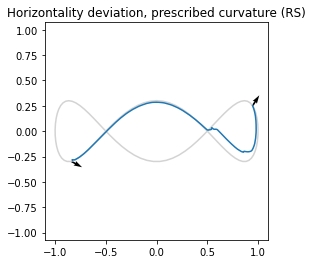

In [56]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (RS)'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);
for x,y,theta in (hfmIn['seed'],hfmIn['tip']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

Note the resilience to the high curvature portions, and to the bad guesses (user provided) of the endpoints tangents.

**TODO** Understand what happens at the second crossing.

In [57]:
# Cigar shaped construction
v_DeviationCurv = ad.array([*γ_tgt_ext, γ_curv_ext])
v_DeviationCurv /= norm(v_DeviationCurv,axis=0)

CigarMetric_CostDeviationCurv = Riemann(
    Outer(v_DeviationCurv)
    + eps**(-2)*(Identity-Outer(v_DeviationCurv))
).with_cost(γ_cost)

In [58]:
hfmIn.update({    
    'metric':CigarMetric_CostDeviationCurv,
    'seed':[*γ(-1.),-0.5],
    'tip': [*γ(1.9),1],  
})

In [59]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0676124095916748 seconds, and 101 iterations.
Post-Processing


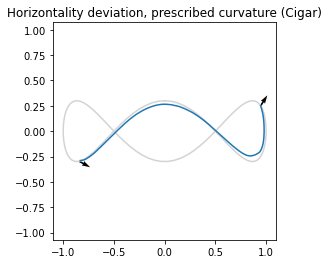

In [60]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);
for x,y,theta in (hfmIn['seed'],hfmIn['tip']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

## 5. Other curvature penalization models


### 5.1 The extended Reeds-Shepp model

We reproduce the above experiment using the extended Reeds shepp model.

In [61]:
hfmIn = Eikonal.dictIn({
    'model':'ReedsSheppExt2',
    'eps':eps, # Relaxation parameter
    
    'seed':[*γ(-1.),-0.5],
    'tip' :[*γ(1.9),1],  
})
hfmIn.SetRect(sides=[[-1,1],[-0.4,0.4]],dimx=101)
hfmIn.nTheta = 101

In [62]:
X2,X2,Theta2 = hfmIn.Grid()

The angular coordinates `Theta2` lies here in $[0,2\pi]$, whereas the previous experiments involved `Theta`$\in [-\pi,\pi]$.
For consistency, one has to *rool* the arrays, around their last coordinate.

In [63]:
angleDiff = np.roll(Theta[0,0,:],51)-Theta2[0,0,:]
np.max(np.abs(angleDiff*(2.*np.pi+angleDiff)))

array(2.9960565e-06, dtype=float32)

In [64]:
hfmIn.update({
    'cost' : np.roll(γ_cost,51),
    'xi' : 3*xi, # Typical radius of curvature 
    'theta' : np.roll(np.arctan2(γ_tgt_ext[1],γ_tgt_ext[0]),51), # Deviation from horizontality
    'kappa' : np.roll(γ_curv_ext,51), # Reference curvature
})

In [65]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.06248641014099121 seconds, and 84 iterations.
Post-Processing


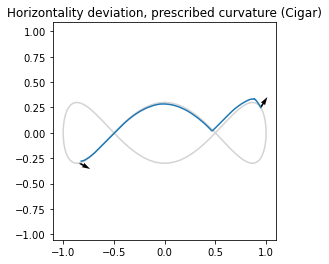

In [66]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);
for x,y,theta in (hfmIn['seed'],hfmIn['tip']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

### 5.2 Other models

The same parameters apply to the extended Reeds-Shepp forward, Euler elastica, and Dubins models. 

In [67]:
hfmIn['model'] = 'ElasticaExt2_5'

In addition, since these models are asymmetric, even greater portions of the tubular structure can be extracted in a single run

In [68]:
hfmIn['tip'] = lift(γ,3.1)

In [69]:
if xp is not np: 
    # Bug : The gpu solver requires one of these options, otherwise IllegalMemoryAccess. Reason unclear.
#    hfmIn['solver']='AGSI' (default is 'FIM' here)
    hfmIn['precompute_scheme']=True

In [71]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.25441527366638184 seconds, and 249 iterations.
Post-Processing


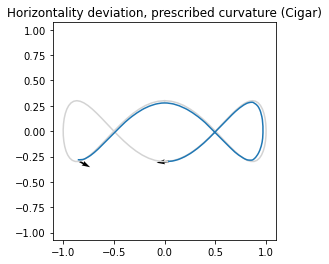

In [72]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);
for x,y,theta in (hfmIn['seed'],hfmIn['tip']): plt.quiver(x,y,np.cos(theta),np.sin(theta))

Also, exchanging the role of the seeds and tips allows to extract the other portion of tube. 

In [114]:
hfmIn['seed'],hfmIn['tip'] = hfmIn['tip'],hfmIn['seed']

In [112]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.4062869548797607 seconds, and 387 iterations.
Post-Processing


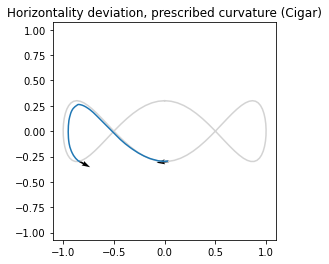

In [113]:
fig = plt.figure(figsize=[4,4]); plt.title('Horizontality deviation, prescribed curvature (Cigar)'); plt.axis('equal'); 
plt.plot(*γ(T),color='lightgray')
plt.plot(*hfmOut['geodesic'][[0,1]]);
for x,y,theta in (hfmIn['seed'],hfmIn['tip']): plt.quiver(x,y,np.cos(theta),np.sin(theta))